<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 6: More Feature Engineering</h2>
<br>

This notebook is continuation of the Week 6 tutorial. 

<a href="#1.-Ames-Housing-Data">Ames Housing Data</a> <br>
<a href="#2.-Ordinal-predictors">Ordinal predictors</a> <br>
<a href="#3.-Discrete-predictors">Discrete predictors</a> <br>
<a href="#4.-Interaction-features">Interaction features</a> <br>
<a href="#5.-Missing-values">Missing values</a> <br>


In [38]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [39]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [40]:
# Methods
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

In [41]:
# This code is more advanced, you don't have to worry about it
def validate(models):
    
    ols, X_val = dict(), dict()
    
    y_train = data.loc[index_train, 'LogSalePrice']

    for i in models.keys(): # looping over the keys of the dictionary
        X_train =  data.loc[index_train, models[i]]
        X_val[i] = data.loc[index_val, models[i]]
        ols[i] = LinearRegression().fit(X_train, y_train)

    # Initialise table
    rows = models.keys()
    columns=['RMSE', 'R-Squared', 'MAE']
    results = pd.DataFrame(0.0, columns=columns, index=rows)

    for i, key in enumerate(models.keys()):
        y_pred = ols[key].predict(X_val[key])
        results.iloc[i, 0] = np.sqrt(mean_squared_error(y_val, y_pred))
        results.iloc[i, 1] = r2_score(y_val, y_pred)
        results.iloc[i, 2] = mean_absolute_error(y_val, y_pred)

    return results.round(3)

## 1. Ames housing data

In [42]:
data=pd.read_hdf('Data/Ames.h5', 'data')
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_Other,NeighborhoodGLMM
0,20,RL,141.0,31770,NaN,IR1,Lvl,Corner,NAmes,Norm,...,0,0,0,0,0,0,0,0,0,-0.173228
1,20,RH,80.0,11622,NaN,Reg,Lvl,Inside,NAmes,Feedr,...,0,0,0,0,0,0,0,0,0,-0.173228
2,20,RL,81.0,14267,NaN,IR1,Lvl,Corner,NAmes,Norm,...,0,0,0,0,0,0,0,0,0,-0.173228
3,20,RL,93.0,11160,NaN,Reg,Lvl,Corner,NAmes,Norm,...,0,0,0,0,0,0,0,0,0,-0.173228
4,60,RL,74.0,13830,NaN,IR1,Lvl,Inside,Gilbert,Norm,...,0,0,0,0,0,0,0,0,0,0.103834


In [43]:
response = 'LogSalePrice'

index_train, index_val  = train_test_split(data.index, train_size = 0.7, random_state=15)
y_train = data.loc[index_train, response]
y_val = data.loc[index_val, response]

continuous = ['GrLivAreaLog']
nominal_dummies = list(data.columns[data.columns.str.match(r'^Neighborhood_.*')])

## 2. Ordinal predictors

### 2.1 EDA 

We consider the `OverallQual` variable.

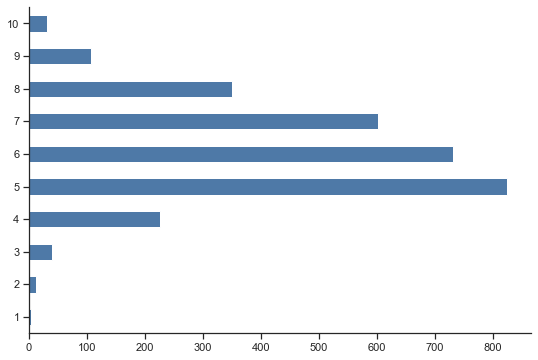

In [44]:
data['OverallQual'].value_counts().sort_index().plot(kind='barh')
sns.despine()
plt.show()

The first level hast too few observations, so merge it with the next one. 

In [45]:
data.loc[data['OverallQual']== 1, 'OverallQual'] = 2

Earlier, we saw that `OverallQual` is the the predictor that has the largest correlation with the response, even though it's an ordinal variable. 

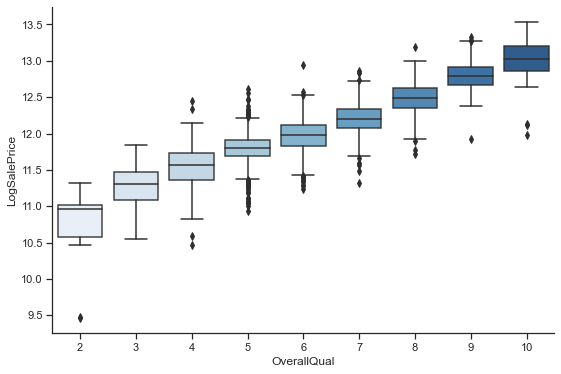

In [46]:
sns.boxplot(x = data['OverallQual'], y = data[response], boxprops=dict(alpha=.9), palette='Blues')
sns.despine()
plt.show()

A regression plot highlights the linear pattern. 

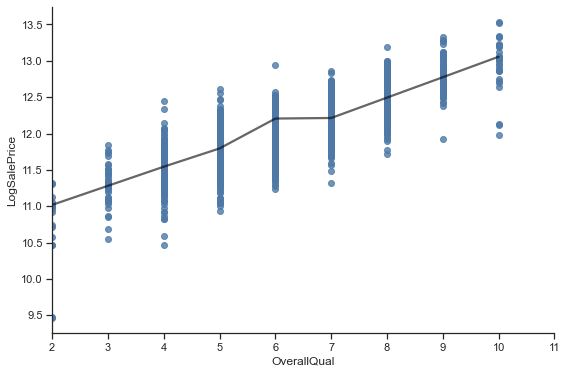

In [10]:
x, y = 'OverallQual', 'LogSalePrice'  # doing this makes the rest of the cell reusable
ax = sns.regplot(data[x], data[y], ci=None, lowess=True, line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_xlim(None, 11)
sns.despine()
plt.show()

### 2.2 Dummy encoding

The standard approach for an ordinal variable in linear regression is to treat it as nominal variable. Unfortunately, doing this discards information from the ordering of the categories. 

Because the EDA reveals a strong linear relationship with the original variable, we should also consider breaking the rule and treating `OverallQual` as numerical even though it's ordinal.

#### Aside

It is a key idea that 

    we should also consider breaking the rule and treating `OverallQual` as numerical even though it's ordinal (categorial variable).
    
There is a key idea in Chess, and really in real life, that you should first learn the rules and then learn when to break the rules. Rules are only rules because they work most of the time. But knowing when to break the rules seperates the good from the best.

In [47]:
variable = 'OverallQual'
dummies = pd.get_dummies(data[variable],  prefix = variable, drop_first=True)
data = data.join(dummies)
ordinal_dummies = list(dummies.columns) 

### 2.3 Ordinal encoding

Consider the kitchen quality.

In [12]:
data['KitchenQual'].value_counts()

TA    1494
Gd    1160
Ex     205
Fa      70
Po       1
Name: KitchenQual, dtype: int64

Here's how to do ordinal encoding, which we can be useful for preliminary analysis and tree-based methods. 

In [48]:
keys = {
        'Po': 1, # poor, noting that we could already merge it with fair here
        'Fa': 2, # fair
        'TA': 3, # typical/average
        'Gd': 4, # good
        'Ex': 5, # excellent
}

variable = 'KitchenQual'
data[variable] = data[variable].replace(keys)

### 2.4 Validation

In [49]:
# Dictionary of predictors for each model
models = dict()
models['Baseline'] = continuous + nominal_dummies
models['Ordinal encoding'] = continuous + nominal_dummies + ['OverallQual']
models['Dummy encoding'] =  continuous + nominal_dummies + ordinal_dummies

# Model validation
results = validate(models)
results

,RMSE,R-Squared,MAE
Baseline,0.213,0.739,0.152
Ordinal encoding,0.177,0.821,0.125
Dummy encoding,0.173,0.827,0.122


## 3. Discrete predictors

### 3.1 EDA

Recall from earlier that `GarageCars` was the numerical predictor that had the third largest correlation with the response. 

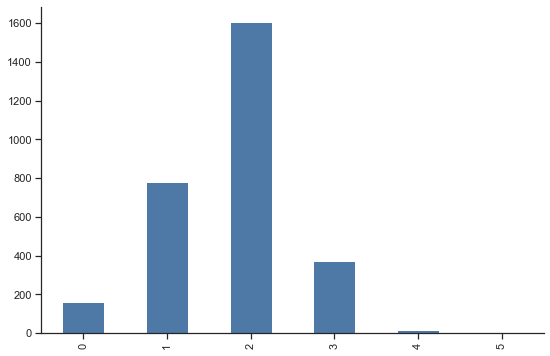

In [50]:
data['GarageCars'] = data['GarageCars'].fillna(0) # there's one missing value, more on this soon
data['GarageCars'] = data['GarageCars'].astype(int)

data['GarageCars'].value_counts().sort_index().plot(kind='bar')
sns.despine()
plt.show()

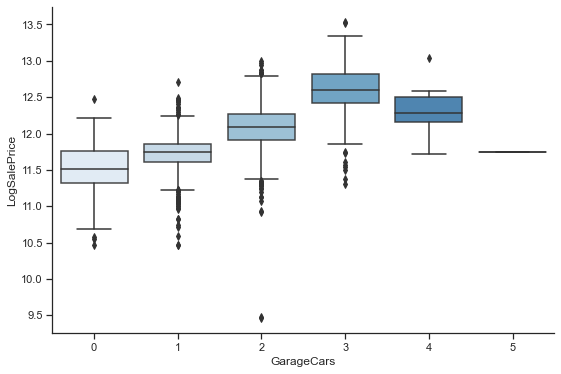

In [51]:
sns.boxplot(x = data['GarageCars'], y = data[response], boxprops=dict(alpha=.9), palette='Blues')
sns.despine()
plt.show()

### 3.2 Features for  nonlinear  modelling

When a discrete predictor seems important and has a low number of distinct values, we can consider creating dummy variables for nonlinear modelling. Intuitively, going from zero to one car spots seems more valuable than going from four to five.   

#### Aside
It is a key idea that
    
    Intuitively, going from zero to one car spots seems more valuable than going from four to five.   

Meaning that we need to use physical intuition, that is we need to use inspiration of what we know of the world, in order to make our models better.

In [52]:
variable = 'GarageCars'
dummies = pd.get_dummies(data[variable],  prefix = variable, drop_first=True)
dummies['GarageCars_4'] = dummies['GarageCars_4'] + dummies['GarageCars_5'] # Merge sparse categories
dummies = dummies.drop('GarageCars_5', axis=1)
data = data.join(dummies)
discrete_dummies = list(dummies.columns)

### 3.3. Validation

The validation results suggest that it doesn't make a difference in the context of a larger model, only in isolation. We are running into diminishing returns in our modelling. 

In [53]:
# Dictionary of predictors for each model
models = dict()
models['Baseline'] = continuous + nominal_dummies + ordinal_dummies
models['Linear'] =   continuous  + nominal_dummies + ordinal_dummies + ['GarageCars']
models['Dummies'] =  continuous +  nominal_dummies + ordinal_dummies + discrete_dummies

# Model validation
results = validate(models)
results

,RMSE,R-Squared,MAE
Baseline,0.173,0.827,0.122
Linear,0.169,0.837,0.117
Dummies,0.169,0.837,0.117


In [19]:
models = dict()
models['Linear'] =   ['GarageCars']
models['Dummies'] =  discrete_dummies

# Model validation
results = validate(models)
results

,RMSE,R-Squared,MAE
Linear,0.315,0.430,0.230
Dummies,0.308,0.457,0.223


In [54]:
discrete = ['GarageCars']

## 4. Interaction effects

### 4.1 EDA

Based on the EDA and our analysis so far, some of the strongest predictors are the size of the house,  quality, and neighbourhood. Combined with our common sense knowledge about real estate prices, that suggests these predictors are promising sources of interaction effects. 

To facilitate visualisation, I create dummies to indicate above average quality and location. 

In [21]:
data['HighQual'] = (data['OverallQual']>5).astype(int)
data['GoodLocation'] = (data['NeighborhoodGLMM']>0).astype(int)

#### Aside
Once again this is an example of feature engineering, and use of real world intuition. If we look at `OverallQual` We see that it is a categorial variable. BUT, we can <b> encode </b> this variable as being high-quality and low-quality. If we do this then we can revel a deeper underlying pattern in the data.

The same idea applies for `NeighborhoodGLMM`.

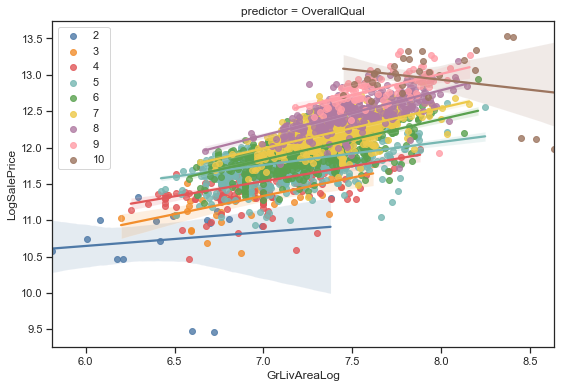

In [22]:
predictor = 'OverallQual'
for val in sorted(data[predictor].unique()):
    split = data[data[predictor] == val]
    sns.regplot(split['GrLivAreaLog'], split['LogSalePrice'], label = round(val, 2))
plt.legend();
plt.title(f'predictor = {predictor}');

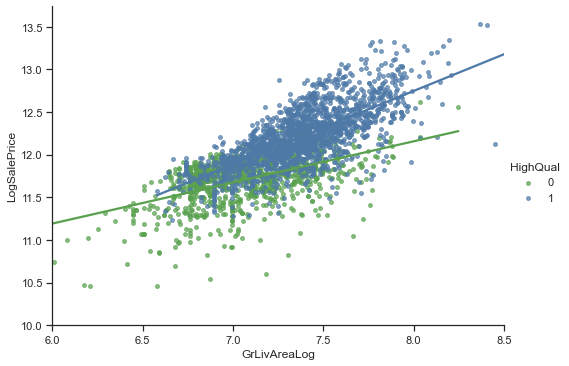

In [23]:
y, x, z = 'LogSalePrice', 'GrLivAreaLog', 'HighQual'
ax = sns.lmplot(x, y, data=data, hue=z, height=5, aspect=1.4, ci=None, 
                scatter_kws={'s': 15,'alpha': 0.7},  palette=np.array(colours)[[4,0]]).ax
ax.set_xlim(6, 8.5)
ax.set_ylim(10, None)
plt.show()

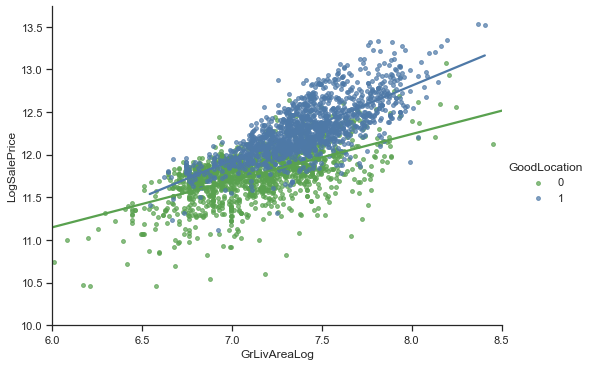

In [24]:
y, x, z = 'LogSalePrice', 'GrLivAreaLog', 'GoodLocation'
ax = sns.lmplot(x, y, data=data, hue=z, height=5, aspect=1.4, ci=None, 
                scatter_kws={'s': 15,'alpha': 0.7},  palette=np.array(colours)[[4,0]]).ax
ax.set_xlim(6, 8.5)
ax.set_ylim(10, None)
plt.show()

### 4.2 Interaction features

We get small gains from the quality interaction. A question for you to think about: why do the interactions effect might look strong in the plots, but contribute little to predictive performance? 

In [25]:
data['AreaXQual'] = data['GrLivAreaLog']*data['HighQual']
data['AreaXLoc'] = data['GrLivAreaLog']*data['GoodLocation']

baseline = continuous + nominal_dummies + ordinal_dummies + discrete

models = dict()
models['Baseline'] = baseline
models['Quality'] =   baseline + ['AreaXQual']
models['Quality and location'] =   baseline + ['AreaXQual'] + ['AreaXLoc'] 

# Model validation
results = validate(models)
results

,RMSE,R-Squared,MAE
Baseline,0.169,0.837,0.117
Quality,0.168,0.839,0.116
Quality and location,0.167,0.840,0.116


In [55]:
interactions = ['AreaXQual']

## 5. Missing values

### 5.1 EDA

We use the `missingno` package to get a sense of missing data patterns.  

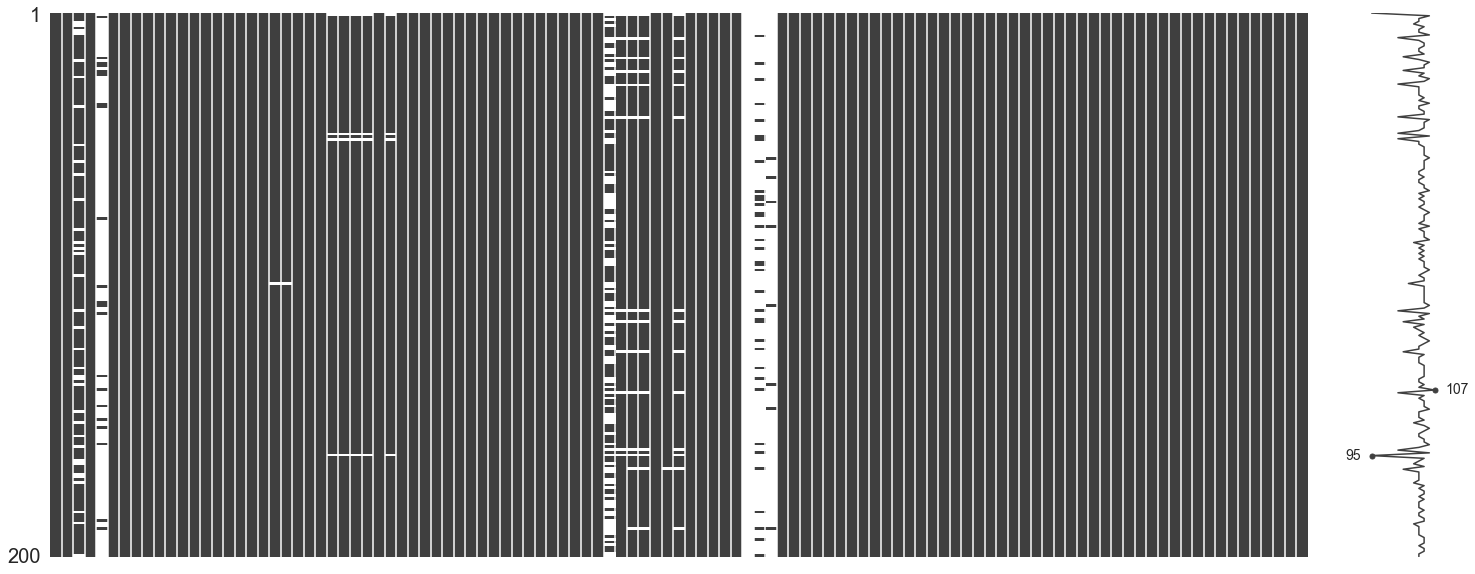

In [56]:
import missingno as msno
msno.matrix(data.sample(200))
plt.show()

Let's now check which predictors have the highest number of missing values.

In [57]:
data.isnull().sum().sort_values(ascending=False).head(10)/len(data)

PoolQC          0.995563
MiscFeature     0.963823
Alley           0.932423
Fence           0.804778
FireplaceQu     0.485324
LotFrontage     0.167235
GarageQual      0.054266
GarageYrBlt     0.054266
GarageFinish    0.054266
GarageType      0.053584
dtype: float64

We conclude that missing values typically occur because the variable is not applicable. 

### 5.2 Variables that are not applicable

In this case, we can create a dummy variable to indicate missingness and set the missing values in numerical variables to zero.  For categorical data, missing is a category. 

A missing value in a predictor that is related to the garage means that the house has no garage

In [29]:
# Indicator variable for no Garage
data['NoGarage'] = data['GarageYrBlt'].isnull().astype(int)
                          
# Fill all missings values with zeros                        
data['GarageArea'] = data['GarageArea'].fillna(0)
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)
data['GarageCars'] = data['GarageCars'].fillna(0)

Bonus: instead of typing and doing things manually, we can use a regular expression (fancy) to find all related predictors. Some are categorical, for these we create the missing category instead. 

In [30]:
data.columns[data.columns.str.match(r'^Garage.*')]

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCars_1', 'GarageCars_2', 'GarageCars_3',
       'GarageCars_4'],
      dtype='object')

#### Aside
This is the easier way to do what we did before

In [31]:
[col for col in data.columns if 'GARAGE' in col.upper()]

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCars_1',
 'GarageCars_2',
 'GarageCars_3',
 'GarageCars_4',
 'NoGarage']

### 5.3 Imputation

As far as I can tell, the only predictor that needs imputation is `LotFrontage`. One option is to simple imputation such as replace missing values by the median (we could do this by neighbourhood):

    imputation is the process of replacing missing data with substituted values

In [32]:
data['LotFrontageSI']=data['LotFrontage'].fillna(data['LotFrontage'].median())

A more sophisticated option is to do imputation as a function of other predictors. 

#### Aside
This means that there are other ways to inpute data. One of the most creative ways to do this is to actually use regression to predict what the values would be. The training data would be the data points in which `LotFrontage` is not missing.

Something else you can also do is use a different data set, and use the regression from that dataset to fill in the missing values. But you have to be careful that the two datasets are similar to each other in spirit.

In [33]:
data.corr()['LotFrontage'].abs().sort_values(ascending=False).head(5).round(5)

LotFrontageSI    1.00000
LotFrontage      1.00000
LotArea          0.49131
1stFlrSF         0.45739
MSSubClass       0.42014
Name: LotFrontage, dtype: float64

The scikit-learn [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) uses all provided features to impute values for each other. In the following cell only `LotFrontage` has missing values, therefore the imputation will be complete in one round. 

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

predictors = ['LotFrontage','LotArea','1stFlrSF','GarageArea','TotalBsmtSF']
X_train = data.loc[index_train, predictors]
imp =  IterativeImputer()
imp.fit(X_train)
data[predictors] = imp.transform(data[predictors])

### 5.4 Validation

The results show that there is at least some benefit from putting the extra effort into the imputation. 

In [35]:
baseline = continuous + nominal_dummies + ordinal_dummies + discrete + interactions

models = dict()
models['Baseline'] = baseline # not lot frontage
models['Simple'] =   baseline + ['LotFrontageSI'] # simple imputation
models['Imputation'] =   baseline + ['LotFrontage'] # iterative imputer

# Model validation
results = validate(models)
results

,RMSE,R-Squared,MAE
Baseline,0.168,0.839,0.116
Simple,0.167,0.839,0.116
Imputation,0.167,0.840,0.115


### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [36]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [37]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')

FileNotFoundError: [Errno 2] No such file or directory: 'css\\jupyter.css'